Based on the Tweet by Joachim Goedhart: https://twitter.com/joachimgoedhart/status/1623678318594629634?s=20&t=G1eC0TRcXOjl0D2tjqX8PQ

This book computes the minimum bounding box of a set of 2D points
This algorithm is based on the fact that: "For the convex polygon, a linear time algorithm for the minimum-area enclosing rectangle is known. It is based on the observation that a side of a minimum-area enclosing box must be collinear with a side of the convex polygon" see wikipedia "Minimum bounding box algorithms"


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread


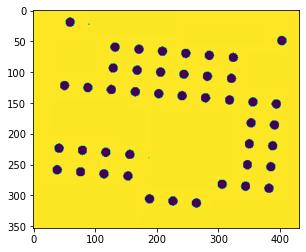

In [2]:
# read image
im = imread("im_data.png")
imgplot = plt.imshow(im)


In [3]:
from skimage.filters import threshold_otsu
from skimage.util import invert

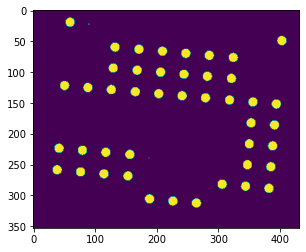

In [4]:
# make sure is binary
thresh = threshold_otsu(im)
bw = invert(im > thresh)
imgplot = plt.imshow(bw)

In [5]:
from skimage.measure import label, regionprops

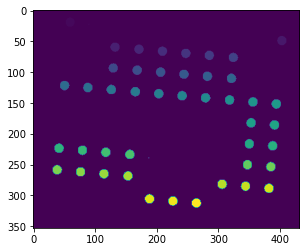

In [6]:
# get centre of points
label_img = label(bw)
plt.imshow(label_img)
regions = regionprops(label_img)

points = np.empty([len(regions),2])
# X = np.empty([len(regions)])

for idx, reg in enumerate(regions):
    x0, y0 = reg.centroid
    # Y[idx] = y0
    # X[idx] = x0
    points[idx,0] = y0
    points[idx,1] = x0

In [7]:
from scipy.spatial import ConvexHull

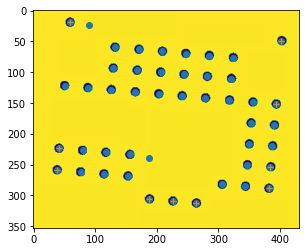

In [8]:
# get convex hull
hull = ConvexHull(points)
hull_points = points[ConvexHull(points).vertices]

plt.imshow(im)
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(hull_points[:,0], hull_points[:,1], '+')


In [9]:
def min_bounding_box(points):

    # calculate convex hull
    hull_points = points[ConvexHull(points).vertices]

    # calculate edges
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    # calculate angles
    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    # reduced to the unique set of first quadrant angles
    angles = np.abs(np.mod(angles, np.pi/2))
    angles = np.unique(angles)

    # create rotation matrix (I am calculating all rotation matrix at the same time) 
    rotations = np.vstack([
            np.cos(angles),
            np.cos(angles-np.pi/2),
            np.cos(angles+np.pi/2),
            np.cos(angles)]).T
    # this reshape is because I calculated many matrices 
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # to get the best bounding box we will look for the one with the smalles area
    # find the edges of the rectangles
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # calculate the areas and find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    mBox = np.zeros((4, 2))
    mBox[0] = np.dot([x1, y2], r)
    mBox[1] = np.dot([x2, y2], r)
    mBox[2] = np.dot([x2, y1], r)
    mBox[3] = np.dot([x1, y1], r)

    return mBox

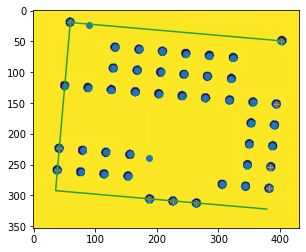

In [10]:
mBox = min_bounding_box(points)

implot = plt.imshow(im)
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(hull_points[:,0], hull_points[:,1], '+')
plt.plot(mBox[:,0], mBox[:,1])

In [11]:
import math
# calculate edges of mBox
edges = np.zeros((len(mBox)-1, 2))
edges = mBox[1:] - mBox[:-1]
d = np.sqrt( np.sum( np.square(edges), axis=0 ))
idx = np.argmax(d)

angle = np.arctan2(edges[idx, 1], edges[idx, 0])
angle_deg = math.degrees(angle)
print(f"Angle to use in degrees: {angle_deg}")


Angle to use in degrees: -175.01755229231912


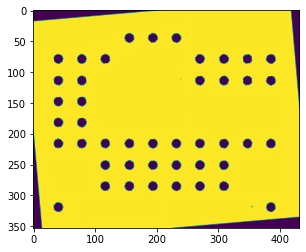

In [12]:
from skimage.transform import rotate
im_rot = rotate(im, angle_deg)
implot = plt.imshow(im_rot)